In [70]:
import sys
import os
sys.path.append('..')
print(sys.path)
from tools.fetching_description_from_huggingface import fetching_description_from_huggingface
from tools.column_parser import column_parser
from typing import TypedDict, Annotated, List
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain.agents import create_tool_calling_agent, AgentExecutor
from pydantic import BaseModel, Field
from langchain.tools import Tool
from firecrawl import FirecrawlApp
from langchain_core.output_parsers import PydanticOutputParser
import pandas as pd
import pprint
from dotenv import load_dotenv
from enum import Enum

['/home/codespace/.python/current/lib/python312.zip', '/home/codespace/.python/current/lib/python3.12', '/home/codespace/.python/current/lib/python3.12/lib-dynload', '', '/home/codespace/.local/lib/python3.12/site-packages', '/home/codespace/.python/current/lib/python3.12/site-packages', '..', '..']


In [71]:
load_dotenv(override=True)

True

In [72]:
# OPENAI_API_KEY='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'
# OPENAI_API_KEY='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'
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
# BASE_URL='https://api.groq.com/openai/v1'
# MODEL="meta-llama/llama-4-scout-17b-16e-instruct"
MODEL=os.getenv("MODEL_NAME")

In [73]:
# df_task = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Public task.csv")
# df_model = pd.read_csv("../Test/data/ISE - AutoCode Challenge 2 Public - Model zoo.csv")
df_task = pd.read_csv("../Test/data/iSE - AutoCode Challenge 2 Private - Public task.csv")
df_model = pd.read_csv("../Test/data/iSE - AutoCode Challenge 2 Private - Model zoo.csv")

In [74]:
df_task

,STT,Task,Validation data
0,1,Bối cảnh của vấn đề:\nNhận dạng chữ viết tay l...,NaN
1,2,Bối cảnh của vấn đề:\nNhận dạng chữ viết tay l...,NaN
2,3,Bối cảnh của vấn đề:\nTrong các bài báo khoa h...,NaN
3,4,Bối cảnh của vấn đề:\nViệc tự động tạo mô tả c...,NaN
4,5,"Bối cảnh của vấn đề:\nTrong thời đại số, các n...",NaN
5,6,Bối cảnh của vấn đề:\nTrong phát triển phần mề...,NaN
6,10,Bối cảnh của vấn đề:\nTrong nhiều ứng dụng như...,NaN


In [75]:
def format_model_list(df):
    model_strings = []
    for i, row in df.iterrows():
        desc = str(row[1]).replace("{", "{{").replace("}", "}}")
        url = str(row[2])
        model_strings.append(f"{i + 1} - {desc} [More info]({url})")
    return "\n".join(model_strings)


In [76]:
def web_scraper(url: str) -> str:
    """Get more details about the model using the model url"""
    # scraper = FirecrawlApp(api_key=os.getenv("FIRECRAWL_API_KEY"))
    # scrape_status = scraper.scrape_url(
    #     url,
    #     formats=['markdown']
    # )
    # return scrape_status.markdown
    result = fetching_description_from_huggingface(url)
    return result

In [77]:
class WebScraperParameters(BaseModel):
    url: str

In [78]:
res = web_scraper('https://huggingface.co/thanhtlx/image_classification_01')

In [79]:
def data_preview(path: str):
    """Get data preview"""
    result = column_parser(path, 5)
    return result

In [80]:
tools = [
    Tool(
        name="web_scrapper",
        func=web_scraper,
        description="Use to get more detail about the model",
        args_schema=WebScraperParameters
    )
]

In [81]:
class Error(Enum):
    MODEL_TOOL_ERROR = "model_tool_error"

In [82]:
class Tasks(BaseModel):
    subtask_one: str = Field(
        ...,
        description="Detailed description of task 1"
    )
    subtask_two: str = Field(
        ...,
        description="Detailed description of task 2"
    )
    subtask_three: str = Field(
        ...,
        description="Detailed description of task 3"
    )
    subtask_four: str = Field(
        ...,
        description="Detailed description of task 4"
    )

In [83]:
class ModelInfo(BaseModel):
    model: str = Field(..., description="Model name and description")
    url: str = Field(..., description="URL to the model")

class ModelSelection(BaseModel):
    models: List[ModelInfo] = Field(..., description="List of available models with name and URL")

In [84]:
class ModelingOutput(BaseModel):
    model_description: str = Field(
        ...,
        description="The detailed description of the model."
    )
    model_input_format: str = Field(
        ...,
        description="Model's detailed input format"
    )
    model_output_format: str = Field(
        ...,
        description="Model's detailed output format"
    )
    model_requirements: str = Field(
        ...,
        description="Requirement libraries need to install to use the model."
    )
    model_sample_code: str = Field(
        ...,
        description="Example code to use the model"
    )

class ModelList(BaseModel):
    models: List[ModelingOutput] = Field(
        ...,
        description="List of suitable model for given task"
    )

In [85]:
class OutputCode(BaseModel):
    code: str = Field(
        ...,
        description="The fixed python code"
    )
    dependencies: list[str] = Field(
        ...,
        description="The new dependencies list"
    )

In [86]:
class Dependencies(BaseModel):
    dependencies: List[str] = Field(
        ...,
        description="List of dependencies that needed to be install"
    )

In [87]:
llm = ChatOpenAI( 
    # base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0.5
)

In [88]:
class AgentState(TypedDict):
    task: HumanMessage | None
    data: str | None
    messages: Annotated[List[BaseMessage], add_messages]
    subtasks: Tasks
    models: ModelSelection
    model_description: str
    model_detailed_list: ModelList
    output_classes: str | None
    code: str | None
    improved_code: str | None
    evaluation_summary: str | None
    dependencies: Dependencies | None
    error: str | None
    run_logs: str | None
    code_runnable: bool | None

In [89]:
def classify_agent(state: AgentState) -> AgentState:
    structured_llm = llm.with_structured_output(Tasks)
    system_prompt = """
        You are an expert in task formulation. Given a machine learning task, you will
        help divide the task into these subtasks:
        - Subtask1: for identifying task description and classify the problem type.
        - Subtask2: for identifying the problem requirements as described in the "Yêu cầu cụ thể cần đạt được" (or other equivalent) section, including: problem requirements, expected input and expected output.
        - Subtask3: for identifying the input format of the problem, as being described in the "Định dạng dữ liệu đầu vào cho bài toán tổng thể" (or other equivalent) section.
        - Subtask4: for identifying the output format of the problem with the given classes, as being described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" (or other equivalent) section.

        You **MUST** follow these guidelines:
        - Do not mistake the output classes with the one described in the problem requirements. The output classes **MUST** contain the classes described in the "Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể" section.
        - Describe the subtasks as specific as possible.
        """
    messages = [SystemMessage(content=system_prompt)]
    messages.append(state['task'])
    result = structured_llm.invoke(messages)
    state['subtasks'] = result
    return state

In [90]:
# task = df_task["Task"][3]

In [91]:
# state = {
#     "task": HumanMessage(content=task),
#     "messages": []
# }

In [92]:
# state = classify_agent(state)

In [93]:
# pprint.pprint(state['subtasks'].subtask_one)
# pprint.pprint(state['subtasks'].subtask_two)
# pprint.pprint(state['subtasks'].subtask_three)
# pprint.pprint(state['subtasks'].subtask_four)


In [94]:
model_selection_parser = PydanticOutputParser(pydantic_object=ModelSelection)

In [95]:
def model_selection_agent(state: AgentState):
    system_prompt = """
                    You are a machine learning expert assigned to select the suitable model for a given task.
                    Given:
                    - A user description about the task
                    - A list of available model (names and links)
                    Your job is to choose ALL suitable models provided in the list for user's specific tasks.
                    Return the answer in the format
                    {structured_output}
                    Here are the list of model:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("user", "{input}")
    ]).partial(structured_output=model_selection_parser.get_format_instructions())

    chain = prompt | llm | model_selection_parser

    result = chain.invoke({"input": state['task'], "model_list": format_model_list(df_model)})
    state['models'] = result
    return state

In [96]:
# state = model_selection_agent(state)
# pprint.pprint(state['models'].models)

In [97]:
def web_scraper_node(state:AgentState) -> AgentState:
    url_list = [model.url for model in state['models'].models]
    ans = "\n".join([web_scraper(url) for url in url_list])
    return ans

In [98]:
def model_selection_using_tool_agent(state: AgentState):
    # system_prompt = """
    #                 You are a machine learning expert assigned to select the **Best-fit model** for a given task.
    #                 Given:
    #                 - A user task description
    #                 - A list of available models (names and url)
    #                 - A tool that fetches model details from a provided URL (it help gathers model description, input/output format, code sample usage)

    #                 Your job is to:
    #                 1. Use the **provided tool** to retrieve real details about each candidate model:
    #                     - ✅ Model description
    #                     - 📥 Input format
    #                     - 📤 Output format
    #                     - 🛠️ Library requirements
    #                     - 🧪 Code sample (usage code snippet)
    #                 2. Select the best model for user given task based on the data that the tool gives you.

    #                 ⚠️ VERY IMPORTANT RULES

    #                 - ❌ DO NOT assume or invent any part of the model's description, input/output format, requirements or code
    #                 - ❌ DO NOT generate fake code or use your own knowledge about the model
    #                 - ✅ ONLY use the **actual output** returned from the tool
    #                 - ✅ Include tool content in your final answer exactly as returned (especially code)

    #                 ## 🧠 Output Structure (Final Answer)

    #                 After retrieving tool results, choose best-fit model for the task (You may need to choose more than one model for some tasks), only choose the model 
    #                 that strictly relevant to the task and only return the output of the model result in the following format:

    #                 **✅ Model name and link**  
    #                 `<model name>` — `<link>`

    #                 **📝 Description (from tool):**  
    #                 <model description>

    #                 **📥 Input format (from tool):**  
    #                 <description of expected input>

    #                 **📤 Output format (from tool):**  
    #                 <description of model output>

    #                 **🛠️ Library Requirements (from tool) **
    #                 <requirements to use the model>

    #                 **🧪 Example code (from tool):**  
    #                 ```python
    #                 <exact code snippet from tool>

    #                 You MUSTN'T return any of your thought process, only the model details.

    #                 Here are the list of models and there corresponding URL:
    #                 {model_list}
    #                 """
    system_prompt = """
                    You are a machine learning expert assigned to select the **Best-fit model** for a given task.
                    Given:
                    - A user task description
                    - A list of detailed description about available models, each model have:
                        - ✅ Model description
                        - 📥 Input format
                        - 📤 Output format
                        - 🛠️ Library requirements
                        - 🧪 Code sample (usage code snippet)

                    Your job is to:
                     - Select the best model for user given task based on the data that the tool gives you.

                    ⚠️ VERY IMPORTANT RULES

                    - ❌ DO NOT assume or invent any part of the model's description, input/output format, requirements or code
                    - ❌ DO NOT generate fake code or use your own knowledge about the model
                    - ❌ DO NOT generate your own model

                    ## 🧠 Output Structure (Final Answer)

                    (You may need to choose more than one model for some tasks), only choose the model that strictly relevant to the task and return the output of the model result in the following format:

                    **📝 Description:**  
                    <model description>

                    **📥 Input format:**  
                    <description of expected input>

                    **📤 Output format:**  
                    <description of model output>

                    **🛠️ Library Requirements **
                    <requirements to use the model>

                    **🧪 Example code (from tool):**  
                    ```python
                    <code snipet>

                    You MUSTN'T return any of your thought process, only the model details.

                    Here are the list of models detail:
                    {model_list}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "{input}")
    ])

    # agent = create_tool_calling_agent(llm=llm, tools=tools, prompt=prompt)
    # executor = AgentExecutor(agent=agent, tools=tools, verbose=True, handle_parsing_errors=True)
    chain = prompt | llm
    model_list = web_scraper_node(state)
    result = chain.invoke({"input": state['task'], "model_list": model_list})
    state['model_description'] = result.content
    return state

In [99]:
# state = model_selection_using_tool_agent(state)

In [100]:
# print(task)

In [101]:
# pprint.pprint(state['model_description'])

In [102]:
parser = PydanticOutputParser(pydantic_object=ModelList)

In [103]:
output_parser_llm = ChatOpenAI(
    # base_url=BASE_URL,
    model=MODEL,
    api_key=OPENAI_API_KEY,
    temperature=0.3
)

In [104]:
def recovery_parser_agent(state: AgentState):
    recovery_prompt = """
        The previous attempt to extract structured data failed.
        You must now attempt to salvage **as much accurate information as possible** from the input text.

        Try to extract the following fields. It's okay to leave some fields blank if information isn't available:
        - `model_description`
        - `model_input_format`
        - `model_output_format`
        - `model_requirements`
        - `model_sample_code`

        Do NOT make up any data. Only extract what you are certain is present in the input.

        Format your output as JSON:
        {formatted_output}
    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', recovery_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())

    chain = prompt | output_parser_llm | parser
    try:
        response = chain.invoke({"input": state['model_description']})
        state['model_detailed_list'] = response
        state['recovery_used'] = True
    except Exception as e:
        print(f"❌ Recovery also failed: {e}")
        state['model_detailed_list'] = {
            "error": "Both primary and recovery parsing failed.",
            "details": str(e),
            "raw_input": state.get('model_description', '')
        }
        state['recovery_used'] = True
    return state


In [105]:
def output_parser_agent(state: AgentState):
    system_prompt = """
                    You are a smart AI tasked with extracting structured technical details about a machine learning model from a reasoning result.
                    You are given a detailed text description about a model (or a list of model).
                    Your goal is to fill the following fields using the data about chosen models based on the text:

                    - `model_description`: A detailed explanation of what the model is and what it does.
                    - `model_input_format`: A detailed description of the model's input format, including dimensions, data types, and expected preprocessing if mentioned.
                    - `model_output_format`: A detailed description of the output format including dimensions, data types, label name and its meaning.
                    - `model_requirements`: A detailed description about the requirements needed to be sastified in order to use the model
                    - `model_sample_code`: A sample code on how to use the model.

                    You MUSTN'T create any data on your own, only using the data provided in the text.

                    You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
                    {formatted_output}
                    """
    prompt = ChatPromptTemplate.from_messages([
        ('system', system_prompt),
        ('human', "{input}")
    ]).partial(formatted_output=parser.get_format_instructions())
    chain = prompt | output_parser_llm | parser
    try:
        response = chain.invoke({"input": state['model_description']})
        state['model_detailed_list'] = response
    except Exception as e:
        print(f"⚠️ Output parsing failed: {e}")
        # Optional: fallback, recovery, or debug output
        state['model_detailed_list'] = {
            "error": "Failed to parse output",
            "details": str(e),
            "raw_input": state.get('model_description', '')
        }
        state = recovery_parser_agent(state)
    return state

In [106]:
# state = output_parser_agent(state)

In [107]:
# ans = state['model_detailed_list']
# for i in range(len(ans.models)):
#     print(f"Model {i}:")
#     pprint.pprint(ans.models[i].model_description)
#     pprint.pprint(ans.models[i].model_input_format)
#     pprint.pprint(ans.models[i].model_output_format)
#     pprint.pprint(ans.models[i].model_requirements)
#     pprint.pprint(ans.models[i].model_sample_code)

In [108]:
def output_agent(state: AgentState) -> AgentState:
    prompt = r"""
        Your are a specialist in machine learning. Your task is to identify the absolute classes of the given problem description, following with an output description.
        ### Input:
        - Problem description: {problem_description}
        - Output description: {output_description}

        You must return an array, strictly following these guidelines:
        - Understand the context from the given problem description.
        - Extract the class names from the output description. You **must not** invent new labels or translate the class names. Use them exactly as given in the output description.
        - Create an array containing the classes.

        You must return only the array containing those classes, without any formatting.
    """

    prompt = prompt.format(
        problem_description = state['task'],
        output_description = state["subtasks"].subtask_four
    )
    response = llm.invoke(prompt)
    return {**state, "output_classes": response.content}

In [109]:
# state = output_agent(state)
# print(state['output_classes'])

In [110]:
llm_planning = ChatOpenAI(
    api_key=OPENAI_API_KEY,
    model=MODEL,
    # base_url=BASE_URL,
    temperature=0.7
)

In [111]:
def planning_agent(state: AgentState) -> AgentState:
    system_prompt = r"""
    You are a highly skilled Machine Learning and Software Engineering planning agent. Your task is to **generate a complete, step-by-step plan** to implement a functional Python solution for a given ML task using a list of provided models.

    ## You will be given:
    1. A detailed problem description
    2. An input specification (format, structure, file type, etc.)
    3. An output specification (expected format and file)
    4. A list of available ML models including:
    - Model name
    - Model description
    - Input format required by the model
    - Output format returned by the model
    - Sample code for inference

    ## Your job:
    You must produce a **complete and detailed implementation plan** that includes:
    - The exact **inputs to load**, and how to parse and preprocess them
    - How to use the provided model(s) correctly, based on their input/output interface
    - Any **transformations** needed to align data with model expectations
    - How to postprocess the model output into the required output format
    - What files should be read and written, and where
    - The **logical structure** of the Python script, broken down into clear sections:
    1. Imports
    2. Preprocessing
    3. Inference
    4. Postprocessing
    5. Output
    - Specific notes about data formats, edge cases, label formats, batch processing (if needed), and whether progress logging (e.g., with `tqdm`) should be included
    - The exact structure of the output file (e.g., CSV column names)
    - Any critical constraints or assumptions that must be enforced

    ## Guidelines:
    - ❌ DO NOT generate Python code.
    - ✅ DO describe **how** the code should be structured and implemented.
    - ✅ Be as detailed and specific as possible in every step.
    - ✅ Use numbered steps or bullet points for clarity.
    - ✅ Use terminology consistent with the model descriptions and problem specification.
    - ❌ DO NOT invent or use models not included in the model list.

    ## Format of your output:
    - A detailed step-by-step plan for how to implement the solution.
    - Break the plan into clear sections corresponding to the pipeline (input → inference → output).
    - Use plain text. No code. No markdown.

    Now generate the plan using the following input:

    Problem description: {problem_description}
    Problem input specification: {input_spec}
    Problem output specification: {output_spec}
    Model list and descriptions: {model_list}
    """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt)
    ])

    chain = prompt | llm_planning

    result = chain.invoke({"problem_description": state['subtasks'].subtask_two,
                           "input_spec": state['subtasks'].subtask_three,
                           "output_spec": state['subtasks'].subtask_four,
                           "model_list": state['model_detailed_list']})
    return result.content

In [112]:
llm_coding = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
    model=os.getenv("MODEL_NAME"),
    temperature=0.5
)

In [113]:
def coding_agent(state: AgentState) -> AgentState:
    base_prompt = r"""
    You are a specialist in Machine Learning. Your task is to generate a *fully functional with all necessary imports and dependencies* codebase in *Python* that can be executed flawlessly.

    You will be provided with:
    - A problem description
    - An input specification
    - An output specification
    - A description of models that you needed to use
    - A list of model to use to solve the problem

    ### Input:
    - Problem description: {problem_description}
    - Problem input specification: {problem_input_description}
    - Problem output specification: {problem_output_description}
    - ML Model list and there detailed description: {model_list}
    - Output classes: {output_classes}

    ### Guidelines

    You *must* strictly follow the following guidelines:
    - DO NOT generate any new input. ONLY use the given input file form the problem input description provided above.
    - If NO input file is provided, assume that the input file will be "test.csv"
    - DO NOT use model that is not provided in the model list. You can only use model from the model list.
    - You *must* ensure that you are calling the model like the described in the model's sample code.
    - You may need to use more than 1 model in the provided list to achieve the task.
    - The preprocessing step should be suitable for the data type.
    - The postprocessing step should notices the differences between the data returned by the model and the output requirements. You must extract and use the exact class labels as defined in the output specification.
    - Do *not invent new labels or translate* the class names. Use them exactly as given.
    - You *must* make sure that your codebase can be executed flawlessly that would not encounter any errors or exceptions.
    - You must add some tqdm to see the infer progress.
    - Output file name MUST be "predictions.csv"

    Your implementation *must strictly follow* the structure below:
    1. *Imports*: All required libraries.
    2. *Preprocessing*: Handle and transform the input as defined.
    3. *Inference logic*: Use the described model for prediction. You *must* use tqdm or similar logging library to track progress.
    4. *Postprocessing*: Format or transform the raw output into the final result as described.
    5. *Output*: Export the predict results into a suitable file as describe above (MUST BE be "predictions.csv")

    You must *not* include any explanations, markdown, or logging outside what is required by the problem.

    Return *only* the complete Python codebase, and you **MUST NOT** include a main function in any way. Wrap it with:
    \`\`\`python
    # code here
    \`\`\`
    """

    prompt = base_prompt.format(
        problem_description=state["task"],
        problem_input_description=state['subtasks'].subtask_three,
        problem_output_description=state['subtasks'].subtask_four,
        model_description=state["model_description"],
        model_list=state['model_detailed_list'].models,
        output_classes=state["output_classes"],
    )
    response = llm.invoke(prompt)
    state['code'] = response.content.replace("```python", "").replace("```", "")
    # return {**state, "code": response.content}
    return state

In [114]:
# state = coding_agent(state)
# print(state['code'])

In [115]:
llm_code_evaluator = ChatOpenAI(
    model= 'gpt-4.1-nano-2025-04-14',
    api_key= os.getenv('OPENAI_API_KEY'),
    temperature=0.25
)

In [116]:
def code_evaluator_agent(state: AgentState) -> AgentState:
    system_prompt = """
    You are an expert code reviewer and machine learning engineer. Your task is to evaluate and improve the given Python code.
    
    You will be provided with:
    - The original code
    - Problem description and requirements
    - Model information
    
    ### Input:
    - Code to evaluate: {code}
    - Problem description: {problem_description}
    - Problem input specification: {problem_input_description}
    - Problem output specification: {problem_output_description}
    - ML model description: {model_description}
    - List of ML model and there details: {model_list}
    - Output classes: {output_classes}

    ### Evaluation Criteria
    - MANDATORY: Ensure input data is preprocess before it go to model
    - MANDATORY: Ensure input data shape of the model in {model_description} exactly matches model's expected input format
    - MANDATORY: Validate tensor dimensions and batch sizes before model prediction
    - MANDATORY: Handle shape mismatches with proper reshaping/preprocessing
    - MANDATORY: Add explicit shape validation and error handling for model I/O
    - MANDATORY: Ensure models input format matches: {model_input_form}
    - MANDATORY: Ensure model output matches: {output_classes}
    - MANDATORY: Add shape debugging information when shape errors occur

    ### Output Format:
    You must return:
    1. An evaluation summary highlighting strengths and areas for improvement
    2. The improved version of the code incorporating all necessary enhancements
    3. You MUST NOT contain logging code
    
    ### STRICT RULES:
    - Ensure input data shape exactly matches model's expected input format
    - You MUST ONLY modify how the model works, including necessary processing steps and the model behaviour. DO NOT change the model architecture or any other code fields.
    - DO NOT generate any new input. Only use the provided input files from the original codebase.
    - DO NOT include any main() function or code block (no if _name_ == "_main_" or similar).
    - DO NOT include any logging code
    - DO NOT change how the output is generated — the output must remain identical in structure and content.
    - ONLY MODIFY THE ORGINAL CODE BASE IF IT IS NECESSARY TO RUNTIME ERRORS
    
    ### EXECUTION REQUIREMENTS
    - Code must be immediately executable without any user intervention
    - Code must export a file of predicted labels in the same format and behaviour in the previous codebase.
    - Results should be generated automatically when the script is run
    
    ### The improved code must:
    - DO NOT change how the output is generated — the output must remain identical in structure and content.
    - Include all necessary imports
    - Only modify the model behaviour and input shapes if being mismatch
    - Add input validation (especially shape validation for ML models)
    - Add proper tensor reshaping to match model's expected input format
    - Handle batch dimensions correctly
    - Add clear error messages for shape mismatches
    - Wrap it with:
    ```python
    # code here
    ```
    """
    prompt = system_prompt.format(
        code=state["code"],
        problem_description=state["task"],
        problem_input_description=state['subtasks'].subtask_three,
        problem_output_description=state['subtasks'].subtask_four,
        model_description=state["model_description"],
        model_list=state['model_detailed_list'],
        model_input_form=[{x.model_description, x.model_input_format} for x in state['model_detailed_list'].models],
        output_classes=state['output_classes']
    )

    response = llm_code_evaluator.invoke(prompt)

    # Extract evaluation summary and improved code from response
    content = response.content
    parts = content.split("```python")
    print(content)
    if len(parts) > 1:
        evaluation_summary = parts[0].strip()
        improved_code = parts[1].split("```")[0].strip()
    else:
        evaluation_summary = content
        improved_code = state["code"]

    return {
        **state,
        "evaluation_summary": evaluation_summary,
        "code": improved_code,
    }
    return state

In [117]:
# state = code_evaluator_agent(state)

In [118]:
# print(state['code'])

In [119]:
dependencies_parser = PydanticOutputParser(pydantic_object=Dependencies)

In [120]:
def dependencies_agent(state: AgentState) -> AgentState:
    system_prompt="""
                You are a code analysis assistant. Given the contents of a Python file, analyze all import and from ... import ... statements to extract the full list of dependencies.
                Your goal is to return a clean list of external modules and packages that would need to be installed via pip in order to run the code.
                Ignore built-in Python modules (like os, sys, math, datetime, etc.).
                Include third-party libraries such as numpy, pandas, requests, etc.
                If a module is imported using an alias (e.g., import numpy as np), resolve it to its base name (numpy).
                Only output the unique package names (not the specific submodules).
                Do not include relative or local imports (e.g., from .utils import helper).
                Use the following known mappings when resolving packages:

                - `PIL` → `pillow`
                - `cv2` → `opencv-python`
                - `sklearn` → `scikit-learn`
                - `yaml` → `pyyaml`
                - `Crypto` → `pycryptodome`
                - `bs4` → `beautifulsoup4`
                - `tensorflow.keras` → `tensorflow`
                - `email` and `html` (standard lib) → DO NOT install
                Input:
                Python code:
                {code}
                
                Output:
                You must always return valid JSON fenced by a markdown code block. Do not return any additional text.
                Here is the output format:
                {formatted_output}
                  """
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
    ]).partial(formatted_output=dependencies_parser.get_format_instructions())

    chain = prompt | llm | dependencies_parser
    try:
        result = chain.invoke({"code": state['code']})
        state['dependencies'] = result.dependencies
        return state
    except Exception as e:
        print(e)
        return state

In [121]:
# state = dependencies_agent(state)

In [122]:
import os
import shutil
import subprocess
import tempfile
from pathlib import Path
import venv

def code_execute_agent(
    input_path,
    output_path,
    code: str,
    requirements=None,
    timeout: int = 120,
    venv_path: str = None
):
    if venv_path is None:
        raise ValueError("venv_path must be provided")

    requirements = requirements or []
    input_path = Path(input_path)
    output_path = Path(output_path)
    venv_path = Path(venv_path).resolve()
    python_path = venv_path / "bin" / "python"
    pip_path = venv_path / "bin" / "pip"

    if not python_path.exists():
        print(f"[info] Creating virtual environment at {venv_path}")
        venv.create(venv_path, with_pip=True)

    # Step 1: Install dependencies if provided
    if requirements:
        print(f"[info] Installing packages: {requirements}")
        subprocess.check_call([str(pip_path), "install", *requirements])

    # Temp project workspace
    temp_dir = Path(tempfile.mkdtemp(prefix="code_runner_", dir=Path.cwd()))
    project_dir = temp_dir / "project"

    log_lines = []
    run_err_output = None
    run_err = None

    try:
        os.makedirs(project_dir, exist_ok=True)

        # Copy input
        if input_path.exists():
            if input_path.is_dir():
                dest = project_dir / input_path.name
                shutil.copytree(input_path, dest, dirs_exist_ok=True)
            else:
                shutil.copy2(input_path, project_dir / input_path.name)

        # Write code to main.py
        main_file = project_dir / "main.py"
        main_file.write_text(code)

        # Run with realtime logging
        process = subprocess.Popen(
            [str(python_path), "main.py"],
            cwd=project_dir,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True
        )

        try:
            for line in process.stdout:
                print(line, end="")
                log_lines.append(line)
            process.wait(timeout=timeout)
        except subprocess.TimeoutExpired:
            process.kill()
            run_err_output = ''.join(log_lines)
            raise RuntimeError("Code execution timed out.")

        if process.returncode != 0:
            run_err_output = ''.join(log_lines)
            raise RuntimeError(f"Execution failed:\n{run_err_output}")

        # Save result
        produced_file = project_dir / output_path.name
        if not produced_file.exists():
            raise FileNotFoundError(f"Expected output file not found: {produced_file}")
        output_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(produced_file, output_path)

        return False, ''.join(log_lines)  #  no error, logs
    except Exception as e:
        print(e)
        if not run_err_output:
            run_err_output = ''.join(log_lines) or str(e)
        return True, run_err_output # error, logs
    finally:
        shutil.rmtree(temp_dir, ignore_errors=True)


# File input

In [123]:
def code_execution_agent(state: AgentState) -> AgentState:
    is_error, logs = code_execute_agent(
    "../Test/data/Task_5/test.csv",
    "predictions.csv",
    state["code"],
    state['dependencies'],
    1200000,
    "Project/venv"
    )

    state['run_logs'] = logs
    # state['run_logs'] = logs.splitlines()[-100:]
    if is_error:
        state['code_runnable'] = False
    else:
        state['code_runnable'] = True
    return state

In [124]:
def code_acceptance_evaluate_node(state: AgentState) -> str:
    if state['code_runnable']:
        return "continue"
    return "repair"

In [125]:
output_code_parser = PydanticOutputParser(pydantic_object=OutputCode)

In [126]:
def code_detection_agent(state: AgentState) -> AgentState:
    system_prompt="""
                You are a Python code repair agent.

                You will be given:
                1. {code}: the original Python code that failed to run.
                2. {run_logs}: the full output generated during execution.
                3. {task}: the detailed description about the task.
                4. {model_list}: details of available model.
                5. {dependencies}: the list of current dependencies.

                Your job is to:
                - Analyze the run log.
                - Determine the cause of the failure.
                - Modify the `code` to fix the problem.
                - Modify the dependencies list to run the new code.
  (✅ You can only ADD new modules to the current list. ❌ You MUST NOT override or remove existing entries.)
                - Ensure the new code runs without that error.

                ⚠️ IMPORTANT:
                - You must return only the fixed code as plain Python source.
                - Do not include any explanation, comments, or output formatting.
                - Do not print or log anything — just return the corrected code.
                - If a package is missing (e.g. `ModuleNotFoundError`), import it only if it's part of the Python ecosystem.
                - Do not include shell commands like `pip install ...`. Assume dependencies are already installed or will be handled externally.

                Example input:
                - If `error_log` says `ModuleNotFoundError: No module named 'tf_keras'`, you will add 'tf_keras' to the dependency list and just update the code to use it appropriately.

                Your output must be the corrected Python script only. It must be in the following format:
                {formatted_output}
                  """

    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt)
    ]).partial(formatted_output=output_code_parser.get_format_instructions())
    print("------------------------------START LOGS-----------------------------------")
    print(state['run_logs'])
    print("_----------------------------END LOGS--------------------------------------")
    chain = prompt | llm_code_evaluator | output_code_parser
    result = chain.invoke({"task": state['task'], "code": state['code'], "run_logs": state['run_logs'], "dependencies": state['dependencies'], "model_list": state['model_detailed_list']})
    state['code'] = result.code
    state['dependencies'] = result.dependencies
    return state

In [127]:
def fallback_model_selection_tool_node(state: AgentState):
    if state['error'] == Error.MODEL_TOOL_ERROR:
        return "repeat"
    return "continue"

In [128]:
def init_agent(state: AgentState):
    state = {
        "messages": [],
        "task": state["task"],
        "data": None,
        "subtasks": None,
        "models": None,
        "model_detailed_list": None,
        "output_classes": None,
        "code": None,
        "dependencies": None,
        "run_logs": None,
        "error": None,
        "code_runnable": None
    }
    return state

In [129]:
graph = StateGraph(AgentState)
graph.add_node("fallback_model_selection", lambda state: state)
graph.add_node("init_node", init_agent)
graph.add_node("formulation_node", classify_agent)
graph.add_node("model_selection_node", model_selection_agent)
graph.add_node("model_selection_using_tool_node", model_selection_using_tool_agent)
graph.add_node("model_output_parser_node", output_parser_agent)
graph.add_node("labeling_node", output_agent)
graph.add_node("coding_node", coding_agent)
graph.add_node("evaluation_node", code_evaluator_agent)
graph.add_node("dependencies_node", dependencies_agent)
graph.add_node("execution_node", code_execution_agent)
graph.add_node("code_acceptance_evaluate_node", lambda state: state)
graph.add_node("detection_node", code_detection_agent)

graph.add_edge(START, "init_node")
graph.add_edge("init_node", "formulation_node")
graph.add_edge("formulation_node", "model_selection_node")
graph.add_edge("model_selection_node", "model_selection_using_tool_node")
graph.add_edge("model_selection_using_tool_node", "fallback_model_selection")
graph.add_conditional_edges(
    "fallback_model_selection",
    fallback_model_selection_tool_node,
    {
        "continue": "model_output_parser_node",
        "repeat": "model_selection_using_tool_node"
    }
)
graph.add_edge("model_output_parser_node", "labeling_node")
graph.add_edge("labeling_node", "coding_node")
graph.add_edge("coding_node", "evaluation_node")
graph.add_edge("evaluation_node", "dependencies_node")
graph.add_edge("dependencies_node", "execution_node")
graph.add_edge("execution_node", "code_acceptance_evaluate_node")
graph.add_conditional_edges(
    "code_acceptance_evaluate_node",
    code_acceptance_evaluate_node,
    {
        "continue": END,
        "repair": "detection_node"
    }
)
graph.add_edge("detection_node", "execution_node")

app = graph.compile()

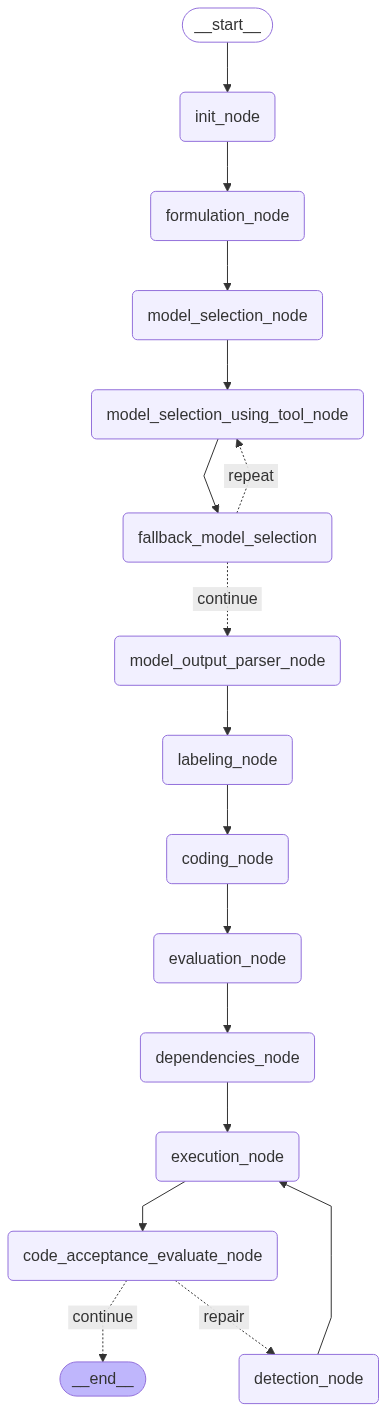

In [130]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [131]:
df_task

,STT,Task,Validation data
0,1,Bối cảnh của vấn đề:\nNhận dạng chữ viết tay l...,NaN
1,2,Bối cảnh của vấn đề:\nNhận dạng chữ viết tay l...,NaN
2,3,Bối cảnh của vấn đề:\nTrong các bài báo khoa h...,NaN
3,4,Bối cảnh của vấn đề:\nViệc tự động tạo mô tả c...,NaN
4,5,"Bối cảnh của vấn đề:\nTrong thời đại số, các n...",NaN
5,6,Bối cảnh của vấn đề:\nTrong phát triển phần mề...,NaN
6,10,Bối cảnh của vấn đề:\nTrong nhiều ứng dụng như...,NaN


# Task

In [132]:
task_no = 4
task = df_task["Task"][task_no]

In [133]:
print(task)

Bối cảnh của vấn đề:
Trong thời đại số, các nền tảng xem phim và mạng xã hội thu thập được hàng triệu bình luận từ người dùng. Việc tự động phân loại cảm xúc của các bình luận này giúp hệ thống hiểu rõ phản ứng của khán giả đối với phim, hỗ trợ đề xuất nội dung, sàng lọc bình luận tiêu cực hoặc phân tích xu hướng dư luận. Bài toán phân loại cảm xúc văn bản là một trong những ứng dụng phổ biến của xử lý ngôn ngữ tự nhiên (NLP), đặc biệt hữu ích trong tiếng Việt, nơi dữ liệu phi cấu trúc ngày càng tăng.

Yêu cầu cụ thể cần đạt được:
Xây dựng một ứng dụng có khả năng phân loại cảm xúc của câu bình luận phim viết bằng tiếng Việt.
Ứng dụng cần đọc đầu vào là một câu bình luận và dự đoán xem câu đó mang cảm xúc gì.

Định dạng dữ liệu đầu vào cho bài toán tổng thể:
Một file test.csv, các dòng là các example có các cột 
ID: Id của example
text: Một câu văn bằng tiếng Việt, ví dụ: "Phim hay quá, cảm động vô cùng!"

Định dạng kết quả đầu ra mong muốn cho bài toán tổng thể:
File ouput.csv các dòn

In [ ]:
state = app.invoke({"task": task})

/tmp/ipykernel_22722/7332665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  desc = str(row[1]).replace("{", "{{").replace("}", "}}")
/tmp/ipykernel_22722/7332665.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  url = str(row[2])


**Evaluation Summary:**

The original code correctly processes Vietnamese text comments for sentiment classification using a pretrained BERT-based model. It performs tokenization, inference, and maps predicted classes to sentiment labels. However, it lacks explicit validation of tensor shapes and input dimensions, which can lead to runtime errors if the model expects a specific input shape or batch size. Since the model is based on TensorFlow and expects batched inputs, it's crucial to ensure that each input is correctly shaped, especially when processing single samples.

**Strengths:**
- Clear and straightforward implementation.
- Proper use of tokenizer and model inference.
- Correct mapping of logits to labels.

**Areas for Improvement:**
- Validate and ensure input tensors match the model's expected shape.
- Explicitly reshape inputs if necessary.
- Add error handling for shape mismatches.
- Maintain the original output format and logic.

---

**Improved Code:**

```python
# code h


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: /workspaces/ISE-challenge/src/Project/venv/bin/python3 -m pip install --upgrade pip


2025-06-21 03:19:11.988693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750475952.003946   30598 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750475952.008637   30598 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750475952.021555   30598 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750475952.021583   30598 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750475952.021585   30598 computation_placer.cc:177] computation placer alr

In [ ]:
ans = state['model_detailed_list']
for i in range(len(ans.models)):
    print(f"Model {i}:")
    pprint.pprint(ans.models[i].model_description)
    pprint.pprint(ans.models[i].model_input_format)
    pprint.pprint(ans.models[i].model_output_format)
    pprint.pprint(ans.models[i].model_requirements)
    pprint.pprint(ans.models[i].model_sample_code)

Model 0:
('Mô hình BLIP (Bootstrapping Language–Image Pre‑training) sử dụng Vision '
 'Transformer (ViT) để tạo ra mô hình hiểu và mô tả hình ảnh một cách linh '
 'hoạt, bao gồm cả các tác vụ như image captioning, image–text retrieval và '
 'visual question answering.')
('Hình ảnh: RGB. Kích thước đầu vào: bất kỳ, vì BlipProcessor sẽ tự resize và '
 "crop center về 224×224. Prompt (tuỳ chọn): ví dụ 'a photo of' cho "
 'image-to-text có định hướng.')
('Caption ở dạng chuỗi văn bản (string), đã được decode qua tokenizer. Có thể '
 'lấy logits của từng token nếu cần.')
'pip install torch torchvision transformers pillow'
('import requests\n'
 'from PIL import Image\n'
 'from transformers import BlipProcessor, BlipForConditionalGeneration\n'
 'processor = BlipProcessor.from_pretrained("zhaospei/Model_14")\n'
 'model = BlipForConditionalGeneration.from_pretrained("zhaospei/Model_14")\n'
 'url = '
 '"https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg"\n'
 'raw_image = I

In [ ]:
print(state['code'])

# Improved code with explicit shape validation and proper input handling
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load images from the 'images' directory
image_dir = 'images'
image_files = [f for f in os.listdir(image_dir) if f.endswith(('png', 'jpg', 'jpeg'))]

# Initialize the model and processor
processor = BlipProcessor.from_pretrained("zhaospei/Model_14")
model = BlipForConditionalGeneration.from_pretrained("zhaospei/Model_14")
model.eval()  # Set model to evaluation mode

predictions = []

for image_file in tqdm(image_files, desc="Processing images"):
    image_path = os.path.join(image_dir, image_file)
    raw_image = Image.open(image_path).convert("RGB")
    
    # Prepare inputs for unconditional captioning
    inputs = processor(raw_image, return_tensors="pt")
    
    # Validate input tensor shape
    input_ids = inputs.get('input_ids')
    pixel_values = inp

In [ ]:
print(state['dependencies'])

['pillow', 'pandas', 'tqdm', 'torch', 'transformers']
